This notebook is just a reproduction of the main Hoefling 2022 model training loop on the new `.h5` data export srategy used past March 2024.

In [1]:
import collections.abc
import os
import pickle
import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from openretina.h5_handling import load_h5_into_dict
from openretina.hoefling_2022_configs import model_config, trainer_config
from openretina.hoefling_2022_data_io import natmov_dataloaders_v2
from openretina.hoefling_2022_models import SFB3d_core_SxF3d_readout
from openretina.misc import CustomPrettyPrinter
from openretina.neuron_data_io import make_final_responses
from openretina.plotting import play_stimulus
from openretina.training import standard_early_stop_trainer as trainer

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4)

In [2]:
!ls /Data/fd_export

2024-01-11_movies_dict_8c18928.pkl
2024-01-11_movies_dict_c285329.pkl
2024-01-11_neuron_data_stim_8c18928_responses_99c71a0.pkl
2024-01-11_neuron_data_stim_c285329_responses_0698360.pkl
2024-01-11_neuron_data_stim_c285329_responses_483c12d.pkl
2024-03-22_neuron_data_stim_c285329_responses_483c12d.h5
2024-03-25_neuron_data_responses_484c12d_djimaging.h5
2024-03-27_neuron_data_stim_c285329_responses_483c12d.h5
2024-03-28_neuron_data_responses_484c12d_djimaging.h5
figures
models
movies_8c18928.pkl
movies_c285329.pkl


In [3]:
base_folder = "/Data/fd_export"
data_path = os.path.join(
    base_folder, "2024-03-28_neuron_data_responses_484c12d_djimaging.h5"
)
movies_path = os.path.join(base_folder, "2024-01-11_movies_dict_8c18928.pkl")
responses = load_h5_into_dict(data_path)
stim_dataloaders_dict = make_final_responses(responses)
movies_dict = pickle.load(open(movies_path, "rb"))

Loading HDF5 file contents:   0%|          | 0/1474 [00:00<?, ?item/s]

Upsampling traces to get final responses:   0%|          | 0/67 [00:00<?, ?it/s]

In [4]:
pp.pprint(stim_dataloaders_dict)

{   'session_1_ventral1_20200226': {   'chirp_raw_traces': numpy.ndarray(shape=(131, 1501)),
                                       'chirp_smoothed_traces': numpy.ndarray(shape=(131, 1501)),
                                       'chirp_spike_times': numpy.ndarray(shape=(131, 1501)),
                                       'chirp_spikes': numpy.ndarray(shape=(131, 1501)),
                                       'chirp_traces_times': numpy.ndarray(shape=(131, 1501)),
                                       'chirp_trigger_times': numpy.ndarray(shape=(131, 10)),
                                       'date': '2020-02-26',
                                       'exp_num': 1,
                                       'experimenter': 'Szatko',
                                       'eye': 'left',
                                       'field': 'GCL0',
                                       'group_assignment': numpy.ndarray(shape=(131,)),
                                       'group_confidences': 

In [5]:
np.isnan(stim_dataloaders_dict["session_4_ventral2_20200303"]["responses_final"]).any()

False

In [6]:
np.isnan(stim_dataloaders_dict["session_4_ventral2_20200303"]["natural_spikes"]).any()

True

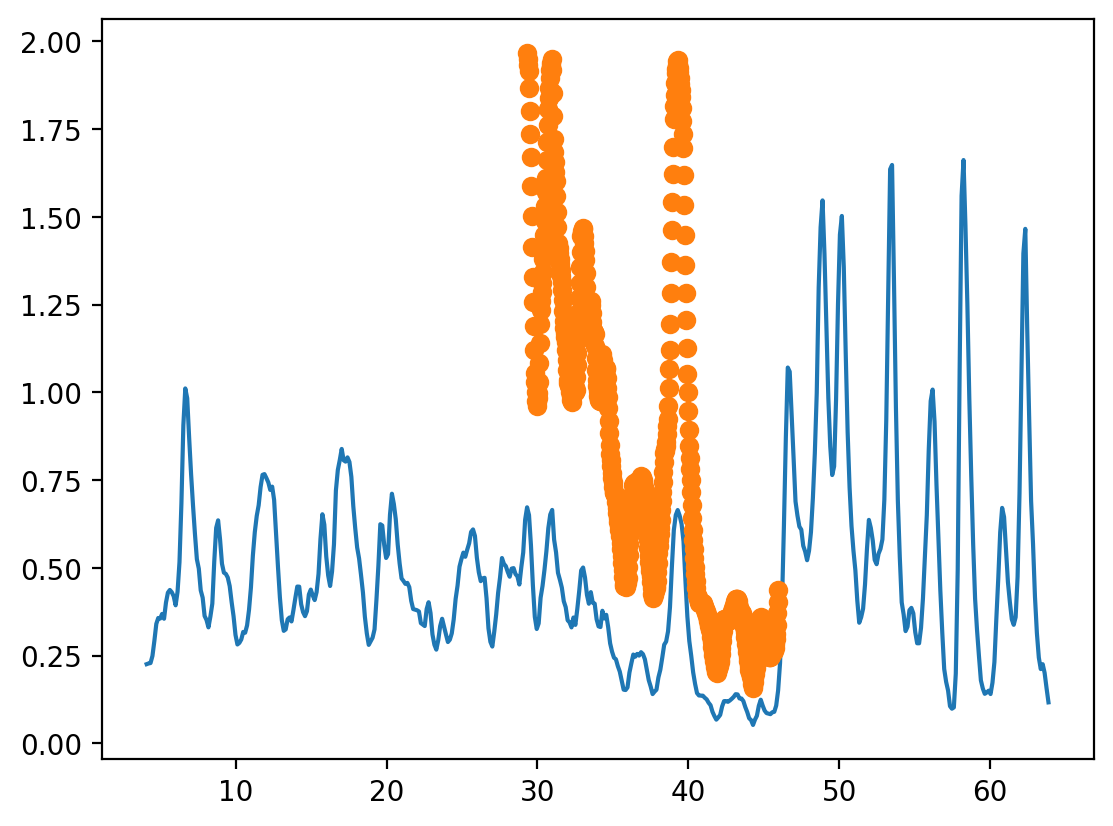

In [7]:
# Visualise upsampling of the stimulus

plt.plot(
    stim_dataloaders_dict["session_4_ventral2_20200303"]["natural_traces_times"][
        0, :500
    ],
    stim_dataloaders_dict["session_4_ventral2_20200303"]["natural_spikes"][0, :500],
)
triggertimes = stim_dataloaders_dict["session_4_ventral2_20200303"][
    "natural_trigger_times"
][0]
upsampled_triggertimes = [np.linspace(t, t + 4.9666667, 5 * 30) for t in triggertimes]
upsampled_triggertimes = np.concatenate(upsampled_triggertimes)
plt.plot(
    upsampled_triggertimes[:500],
    stim_dataloaders_dict["session_4_ventral2_20200303"]["responses_final"][0, :500],
    marker="o",
    linestyle="None",
)

In [8]:
movies_dict.keys()

dict_keys(['eye', 'train', 'test', 'random_sequences'])

In [9]:
dataloaders = natmov_dataloaders_v2(stim_dataloaders_dict, movies_dict, seed=1000)
model = SFB3d_core_SxF3d_readout(**model_config, dataloaders=dataloaders, seed=42)

{'session_1_ventral1_20200226': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 131])}, 'session_1_ventral1_20200528': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 105])}, 'session_1_ventral1_20200707': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 171])}, 'session_1_ventral1_20201021': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 133])}, 'session_1_ventral1_20201030': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 105])}, 'session_1_ventral1_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 120])}, 'session_1_ventral1_20210930': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 107])}, 'session_1_ventral2_20200302': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 121])}, 'session_1_ventral2_20200707': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': t

/Projects/open-retina/openretina/hoefling_2022_models.py:822: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  return mask.T


In [10]:
test_score, val_score, output, model_state = trainer(
    model=model,
    dataloaders=dataloaders,
    seed=1000,
    **trainer_config,
    wandb_logger=None,
)

Random seed 1000 has been set.


/home/bethge/bkr738/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
test_score

0.459370441114146

In [12]:
val_score

0.2753219876779971

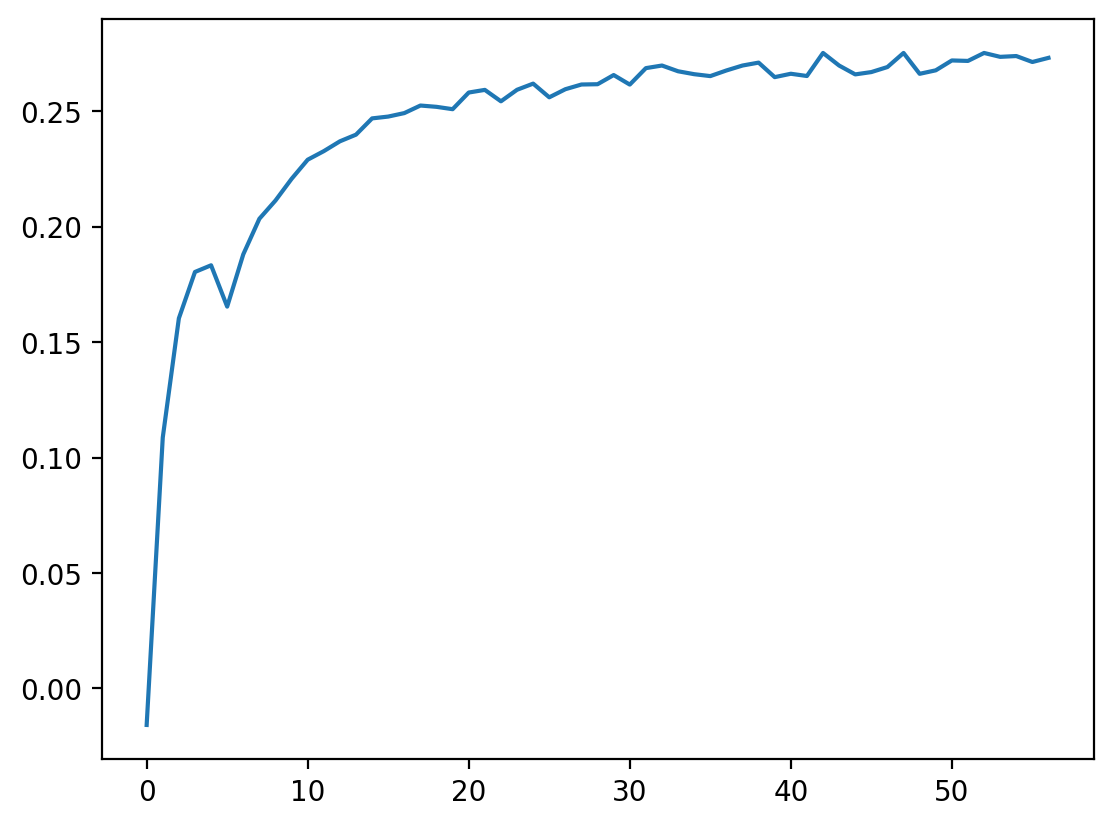

In [13]:
plt.plot(output["val_correlation"])

In [14]:
val_field = "session_2_ventral1_20200303"
val_sample = next(iter(dataloaders["validation"][val_field]))

In [15]:
input_samples = val_sample.inputs
targets = val_sample.targets

In [16]:
input_samples.shape

torch.Size([15, 2, 150, 18, 16])

In [17]:
with torch.no_grad():
    reconstructions = model(input_samples.to("cuda:0"), val_field)

In [18]:
reconstructions = reconstructions.cpu().numpy().squeeze()
targets = targets.cpu().numpy().squeeze()

In [19]:
targets.shape

(15, 150, 131)

In [20]:
reconstructions.shape

(15, 120, 131)

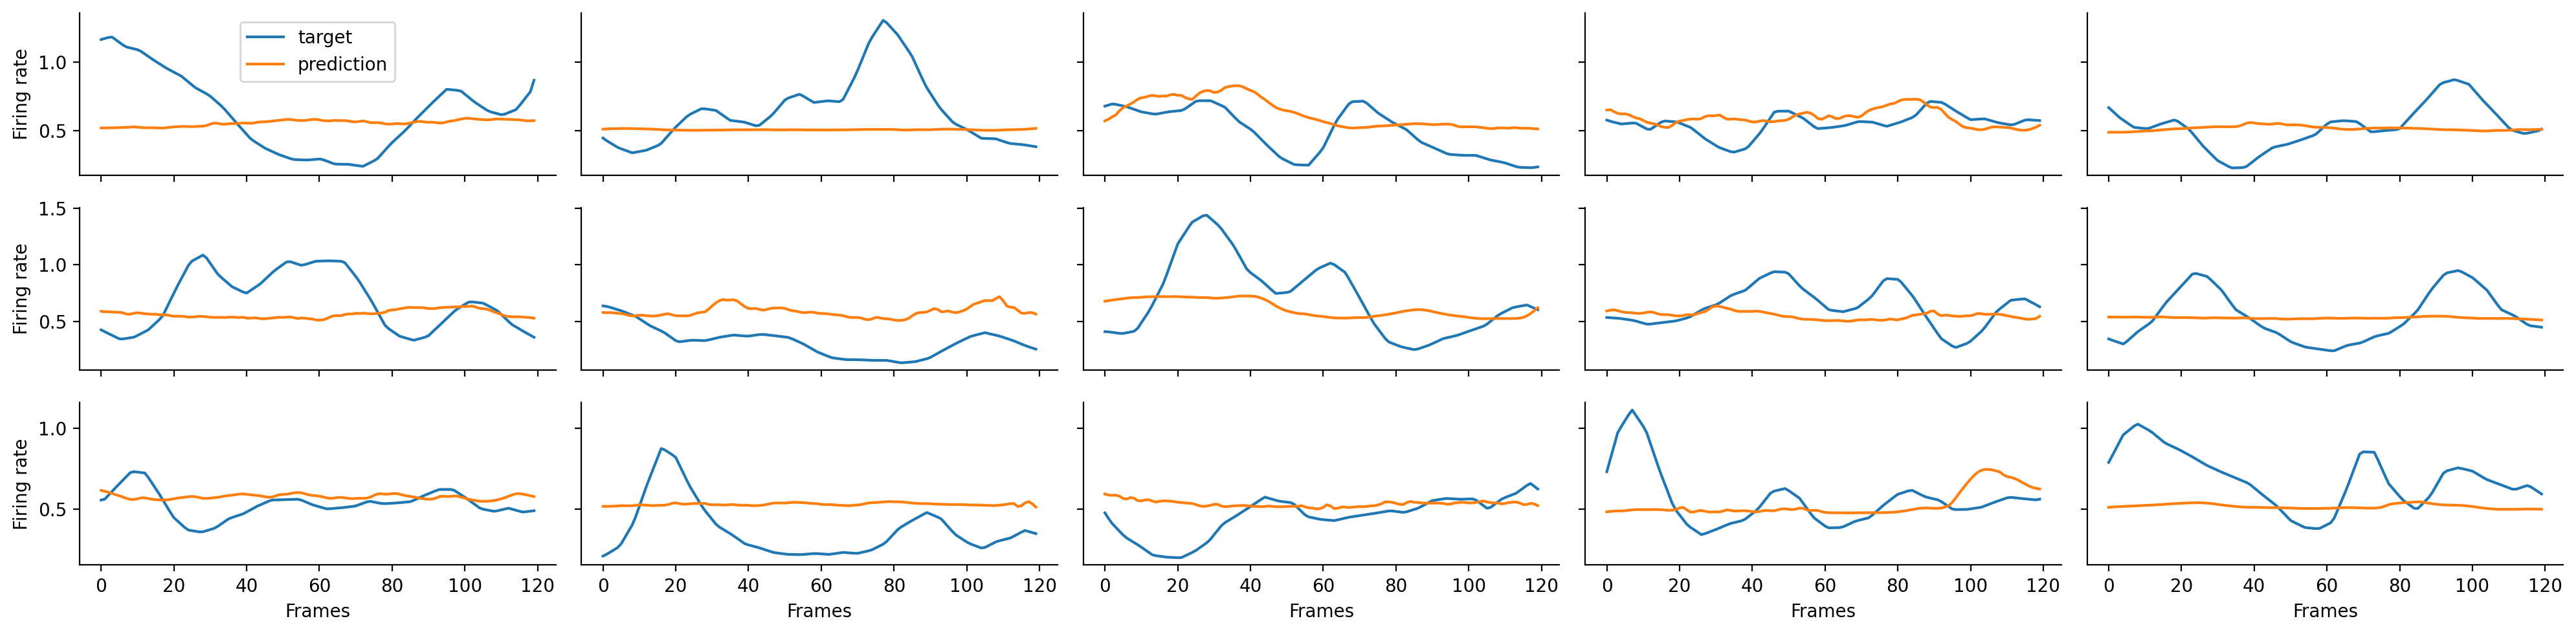

In [21]:
# Your existing code for plotting
neuron = 1
fig, axes = plt.subplots(3, 5, figsize=(20, 5), sharey="row", sharex="col")
for trace_chunk in range(targets.shape[0]):
    ax_idx_1 = trace_chunk // 5
    ax_idx_2 = trace_chunk % 5
    ax = axes[ax_idx_1, ax_idx_2]
    ax.plot(targets[trace_chunk, 30:, neuron], label="target")
    ax.plot(reconstructions[trace_chunk, :, neuron], label="prediction")

    # Set x and y labels for only outer subplots
    if ax_idx_1 == 2:  # Bottom row
        ax.set_xlabel("Frames")
    if ax_idx_2 == 0:  # Leftmost column
        ax.set_ylabel("Firing rate")

    # # Remove inner labels
    # if ax_idx_1 != 2:
    #     ax.set_xticklabels([])
    # if ax_idx_2 != 0:
    #     ax.set_yticklabels([])
    # Only turn on x-axis labels for the bottom row
    if ax_idx_1 == 2:
        ax.tick_params(labelbottom=True)
    else:
        ax.tick_params(labelbottom=False)

    # Only turn on y-axis labels for the leftmost column
    if ax_idx_2 == 0:
        ax.tick_params(labelleft=True)
    else:
        ax.tick_params(labelleft=False)

# Place the legend outside of the subplots
axes[0, 0].legend()

sns.despine()

plt.tight_layout()